# 💥 Includes

This kernel builds TFRecord dataset to be used for Cassava Leaf Disease Classification Challenege. This dataset can be used for cross validation training pipeline for image classification. 

I have used Weights and Biases to show Dataset version control with [Weights and Biases](https://wandb.ai/site).

* Uses Datset from Cassava Leaf Disease Classification Challenge 2019.
* Stratified K-Fold train and validation split. (Here K=5)
* Uses Weights and Biases for dataset version control.
* TFRecords for each fold.

### 🐤 Quick introduction on Weights and Biases Artifacts

You can use W&B Artifacts to store and keep track of datasets, models, and evaluation results across machine learning pipelines. Think of an artifact as a versioned folder of data. You can store entire datasets directly in artifacts, or use artifact references to point to data in other systems.

In this notebook, we will create a [Stratified K-Fold](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/) train and validation split to train image classifiers. Since we are modifying and creating new `csv` files(containing `image_id` and `label`) it's important to incorporate dataset version control in the dataset creating pipeline. This is particularly useful for competitions like these where .5% improvement in score can win you a gold medal. 

Learn more about W&B artifacts [here](https://docs.wandb.ai/artifacts). Check out this [YouTube tutorial](https://www.youtube.com/watch?v=Hd94gatGMic&list=PLD80i8An1OEGajeVo15ohAQYF1Ttle0lk&index=3) as well.

### 👀 Note

This kernel is producing TFRecords with each `.tfrec` file containing similar data distribution. Hence it can be used for Stratified K-Fold training. 

If you want to use the dataset, use this code snippet:

```
import wandb
run = wandb.init()
artifact = run.use_artifact('ayush-thakur/cassava/cassava_tfrecord:v0', type='dataset')
artifact_dir = artifact.download()
```

The [training notebook](https://www.kaggle.com/ayuraj/efficientnet-mixup-k-fold-using-tf-and-wandb) will showcase the use W&B artifacts to download the dataset and train the model. 

# ❄️ Imports and Setups

In [ ]:
!pip install wandb -q

In [ ]:
import tensorflow as tf
print(tf.__version__)

import os
import cv2
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from functools import partial

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

wandb.login(key=wandb_api)

# ⛄ Prepare Dataset

## I. Cassava 2020 Dataset

In [ ]:
train_csv_2020 = '../input/cassava-leaf-disease-classification/train.csv'
train_img_paths_2020 = '../input/cassava-leaf-disease-classification/train_images/'

train_2020_df = pd.read_csv(train_csv_2020)
train_2020_df.head()

In [ ]:
# change image_id to path_to_image_id for ease. 
train_2020_df['image_id'] = train_img_paths_2020 + train_2020_df['image_id'].astype(str)
train_2020_df.to_csv('raw_2020_train.csv', index=False)

train_2020_df.head()

### Save as W&B Artifact for dataset versioning

In [ ]:
run = wandb.init(entity='ayush-thakur', project='cassava', job_type='dataset_creation')
artifact = wandb.Artifact('raw_2020', type='dataset')
artifact.add_file('raw_2020_train.csv')
run.log_artifact(artifact)
run.join()

In [ ]:
# Function to plot the distribution of the dataset.
def show_label_distribution(label_count):
    fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax = sns.countplot(y=label_count, palette='viridis')
    ax.tick_params(labelsize=16)
    
show_label_distribution(train_2020_df['label'].values)

In [ ]:
train_image_names_2020 = os.listdir(train_img_paths_2020)
print('Sample Image Name: ', train_image_names_2020[0])
print('Total number of train images in 2020 challenege: ', len(train_image_names_2020))

## II. Cassava 2019 Dataset

In [ ]:
train_images_2019 = '../input/cassavachallenge/old_competition/train/'

train_label_dirs_2019 = os.listdir(train_images_2019)
print(train_label_dirs_2019)

In [ ]:
label_map = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'

with open(label_map) as json_file: 
    data = json.load(json_file) 
print(f'Label Map: {data}')
    
label_dict = {}
for key, val in data.items():
    if 'CBB' in val:
        label_dict['cbb'] = int(key)
    elif 'CBSD' in val:
        label_dict['cbsd'] = int(key)
    elif 'CGM' in val:
        label_dict['cgm'] = int(key)
    elif 'CMD' in val:
        label_dict['cmd'] = int(key)
    else:
        label_dict['healthy'] = int(key)
        
print(f'\nRestructured label map to: {label_dict}')

In [ ]:
train_image_names_2019 = []
train_2019_labels = []

for dir_name in train_label_dirs_2019:
    # get image names within the dir_name
    image_names = os.listdir(train_images_2019+dir_name)
    image_names = [train_images_2019+dir_name+'/'+img_name for img_name in image_names]
    train_image_names_2019.extend(image_names)
    
    # get label 
    label_name = image_names[0].split('-')[1]
    labels = np.full((len(image_names),), label_dict[label_name])
    train_2019_labels.extend(labels)

In [ ]:
print(f'Total number of train image names: {len(train_image_names_2019)} and labels: {len(train_2019_labels)}')

In [ ]:
# create dataframe
train_2019_df = pd.DataFrame(list(zip(train_image_names_2019, train_2019_labels)),
                            columns=['image_id', 'label'])
train_2020_df.to_csv('raw_2019_train.csv', index=False)

train_2019_df.head()

### Save as W&B Artifact for dataset versioning

In [ ]:
run = wandb.init(entity='ayush-thakur', project='cassava', job_type='dataset_creation')
artifact = wandb.Artifact('raw_2019', type='dataset')
artifact.add_file('raw_2019_train.csv')
run.log_artifact(artifact)
run.join()

In [ ]:
show_label_distribution(train_2019_df['label'].values)

## III. Cassava 2019+2020

In [ ]:
train_df = pd.concat([train_2020_df, train_2019_df]).sample(frac=1).reset_index(drop=True)
train_df.to_csv('cassava_2019_2020.csv', index=False)

train_df.head()

In [ ]:
run = wandb.init(entity='ayush-thakur', project='cassava', job_type='dataset_merge')

artifact_2019 = run.use_artifact('ayush-thakur/cassava/raw_2019:v0', type='dataset')
artifact_2020 = run.use_artifact('ayush-thakur/cassava/raw_2020:v0', type='dataset')

artifact_merge = wandb.Artifact('cassava_2019_2020', type='dataset')

artifact_merge.add_file('cassava_2019_2020.csv')
run.log_artifact(artifact_merge)
run.join()

In [ ]:
show_label_distribution(train_df['label'].values)

# ⚡ Stratified K-Fold Split

Stratified K-Fold ensures that every split will have similar data distribution which is crucial from an imbalanced dataset point of view.

Note: We are going to use K=16. Each split will be converted to `TFRecord`. If we use cross validation training, train and validation split will have same data distribution which is crucial for accurate evaluation of model performance. 

In [ ]:
skf = StratifiedKFold(n_splits=16, shuffle=True)

df_images = train_df['image_id']
df_labels = train_df['label']

In [ ]:
os.makedirs('folds', exist_ok=True)

for fold, (train_index, val_index) in enumerate(skf.split(df_images,df_labels)):
    print(f'Fold Number: {fold} has {len(val_index)} samples')
    
    df_images_tmp, df_labels_tmp = df_images[val_index], df_labels[val_index]
    df_tmp = pd.concat([df_images_tmp, df_labels_tmp], axis=1)
    
    df_tmp.to_csv(f'folds/fold_{fold}.csv', index=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    fig.suptitle(f'File {fold+1}', fontsize=22)
    ax = sns.countplot(y=df_tmp['label'].values, palette='viridis')
    ax.tick_params(labelsize=16)

### Save as W&B Artifact for dataset versioning

In [ ]:
run = wandb.init(entity='ayush-thakur', project='cassava', job_type='dataset_split')

artifact_merge = run.use_artifact('ayush-thakur/cassava/cassava_2019_2020:v0', type='dataset')

artifact_fold = wandb.Artifact('cassava_folds', type='dataset')
artifact_fold.add_dir('folds')
run.log_artifact(artifact_fold)

run.join()

You can visit the W&B project page and click on the Artifact's icon. It's situated at the left hand panel. 

Here's a preview of the graph view of the dataset versioning. 

* The square box is the job type(dataset creation, train, evaluate, etc).
* The round circle is the stored artifact. It can be dataset, model files, results, etc. 

## The Story So Far..

* We created two artifacts - `raw_2019` and `raw_2020` using two different jobs called `dataset_creation`.
* We merged both the dataset during job - `dataset_merge`. The resulting artifact is `cassava_2019_2020`.
* We then did Stratified K-Fold split(K=16) during job - `dataset_split`. The resulting artifact is `cassava_folds`.

At this point each artifact is storing `csv` files. And they can be downloaded to ensure reproducibility using the code snippet which you can find in the **API** tab as shown in the image below. 


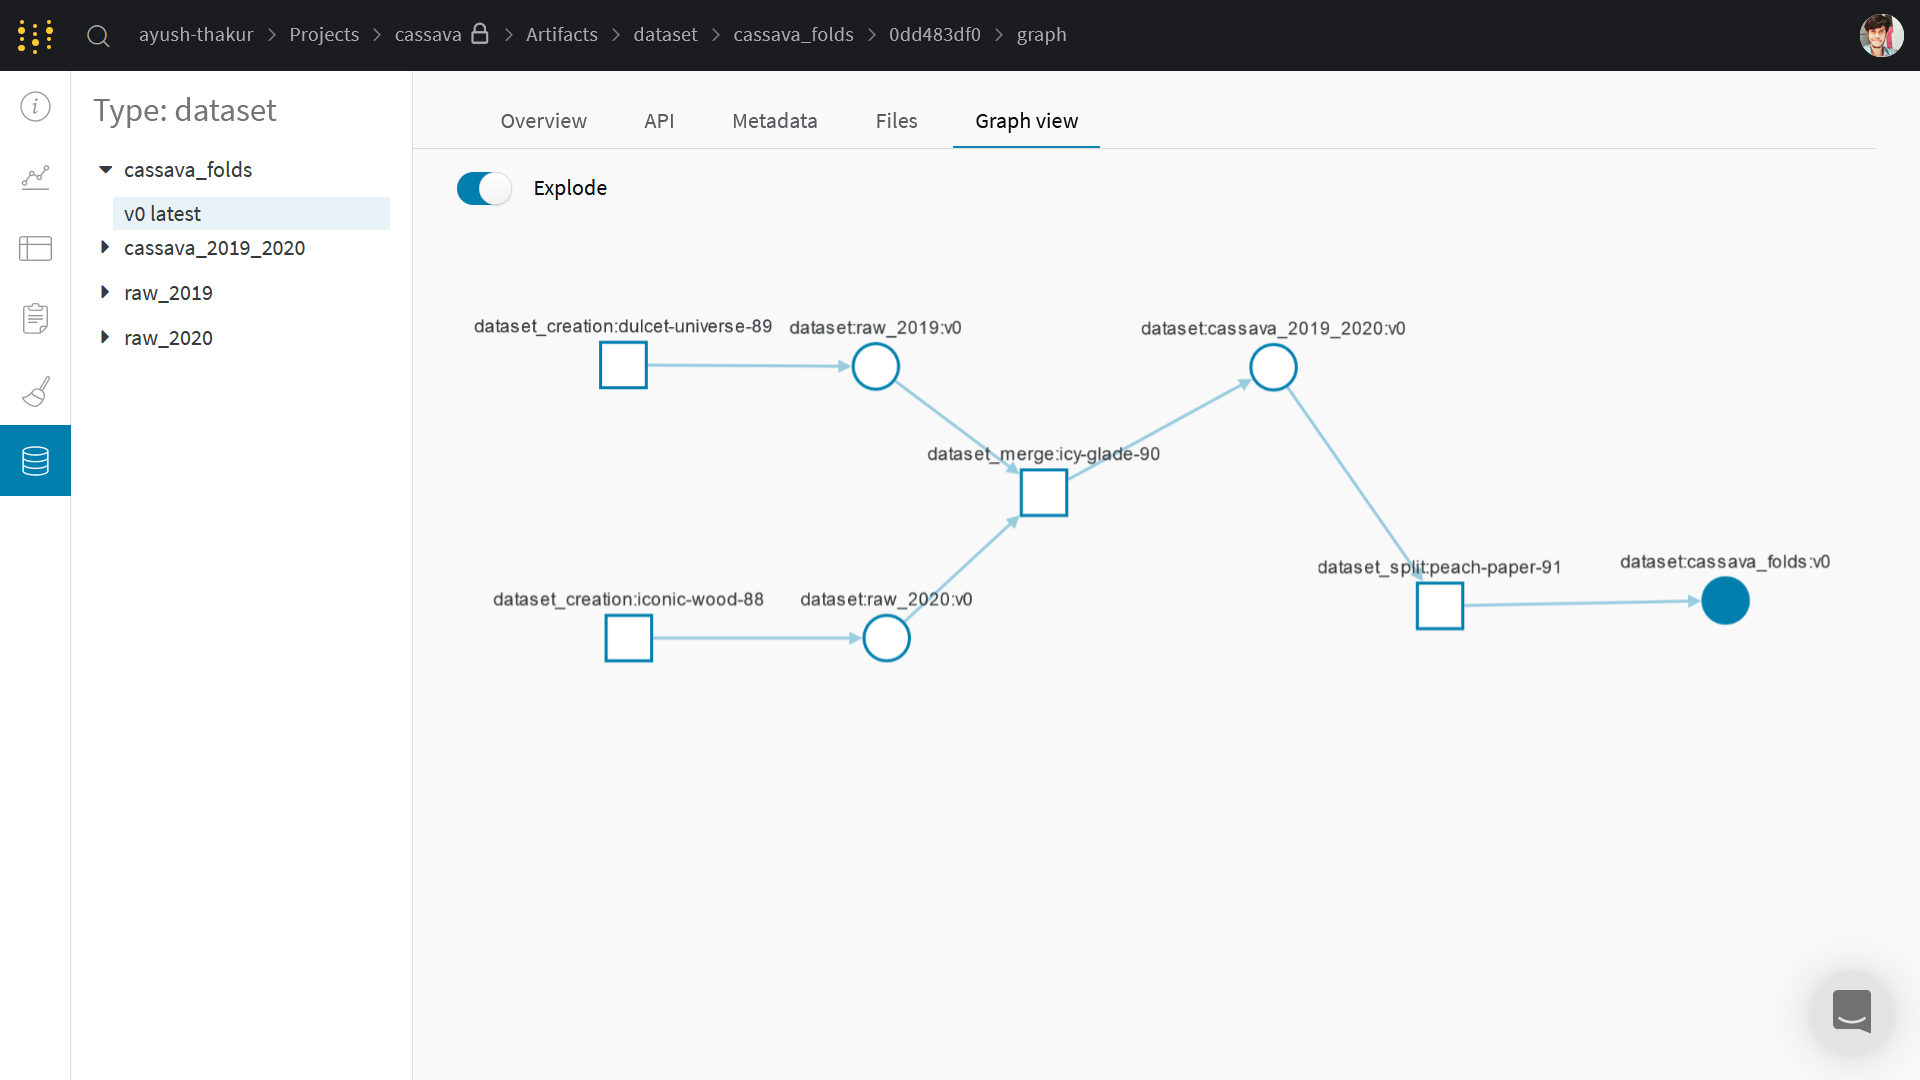


Now we will use these folds and convert them to TFRecord files of different sizes. We will again rely on artifacts for version control and monitoring.

# 🌊 Write TFRecords

## Utils

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(feature0, feature1):
  feature = {
      'image': _bytes_feature(feature0),
      'label': _int64_feature(feature1)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
def TFRecordWriter(count, CSV_FILE_PATH, DEST_PATH):
    # read csv and extract image paths and labels
    df = pd.read_csv(CSV_FILE_PATH)
    IMG_PATHS = df['image_id'].values
    LABELS = df['label'].values
    SIZE = len(IMG_PATHS)

    # make destination dir
    os.makedirs(DEST_PATH, exist_ok=True)

    with tf.io.TFRecordWriter(DEST_PATH+'train%.2i-%i.tfrec'%(count,SIZE)) as writer:
        for j in range(SIZE):
            # get image
            img = cv2.imread(IMG_PATHS[j])
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()

            # get label
            label = LABELS[j]

            # get TFRecord example
            example = serialize_example(img, label)

            writer.write(example)

            if j%100==0: 
                print(j,', ',end='')

## Generate TFRecords

In [ ]:
FOLDS_PATH = './folds/'
CSV_FILES = os.listdir(FOLDS_PATH)

os.makedirs('tfrecords/', exist_ok=True)

for count, csv_file in enumerate(CSV_FILES):
    print(f'Creating TFRecords for: {csv_file}\n')
    
    TFRecordWriter(count,
                   FOLDS_PATH+csv_file,
                  'tfrecords/')
    print('\n')

### Save as W&B Artifact for dataset versioning

In [ ]:
run = wandb.init(entity='ayush-thakur', project='cassava', job_type='dataset_tfrecord')

artifact_folds = run.use_artifact('ayush-thakur/cassava/cassava_folds:v0', type='dataset')

artifact_tfrecord = wandb.Artifact('cassava_tfrecord', type='dataset')
artifact_tfrecord.add_dir('tfrecords')
run.log_artifact(artifact_tfrecord)

run.join()

# Visualize For Sanity Check

In [ ]:
# Decode image from TFRecord file.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [512, 512])
    return image

# Read the TFRecord file.
def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    
    return image, label

# Return tf.data dataset
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

In [ ]:
TFRECORDS = np.array(tf.io.gfile.glob('./tfrecords/train*.tfrec'))     
loader = load_dataset(TFRECORDS[0]).batch(32)

image_batch, label_batch = next(iter(loader))
show_batch(image_batch, label_batch)

We will use this dataset to train an image classifier. I will be using this [training kernel](https://www.kaggle.com/ayuraj/efficientnet-mixup-k-fold-using-tf-and-wandb). 

The final preview of the graph view of the dataset versioning.

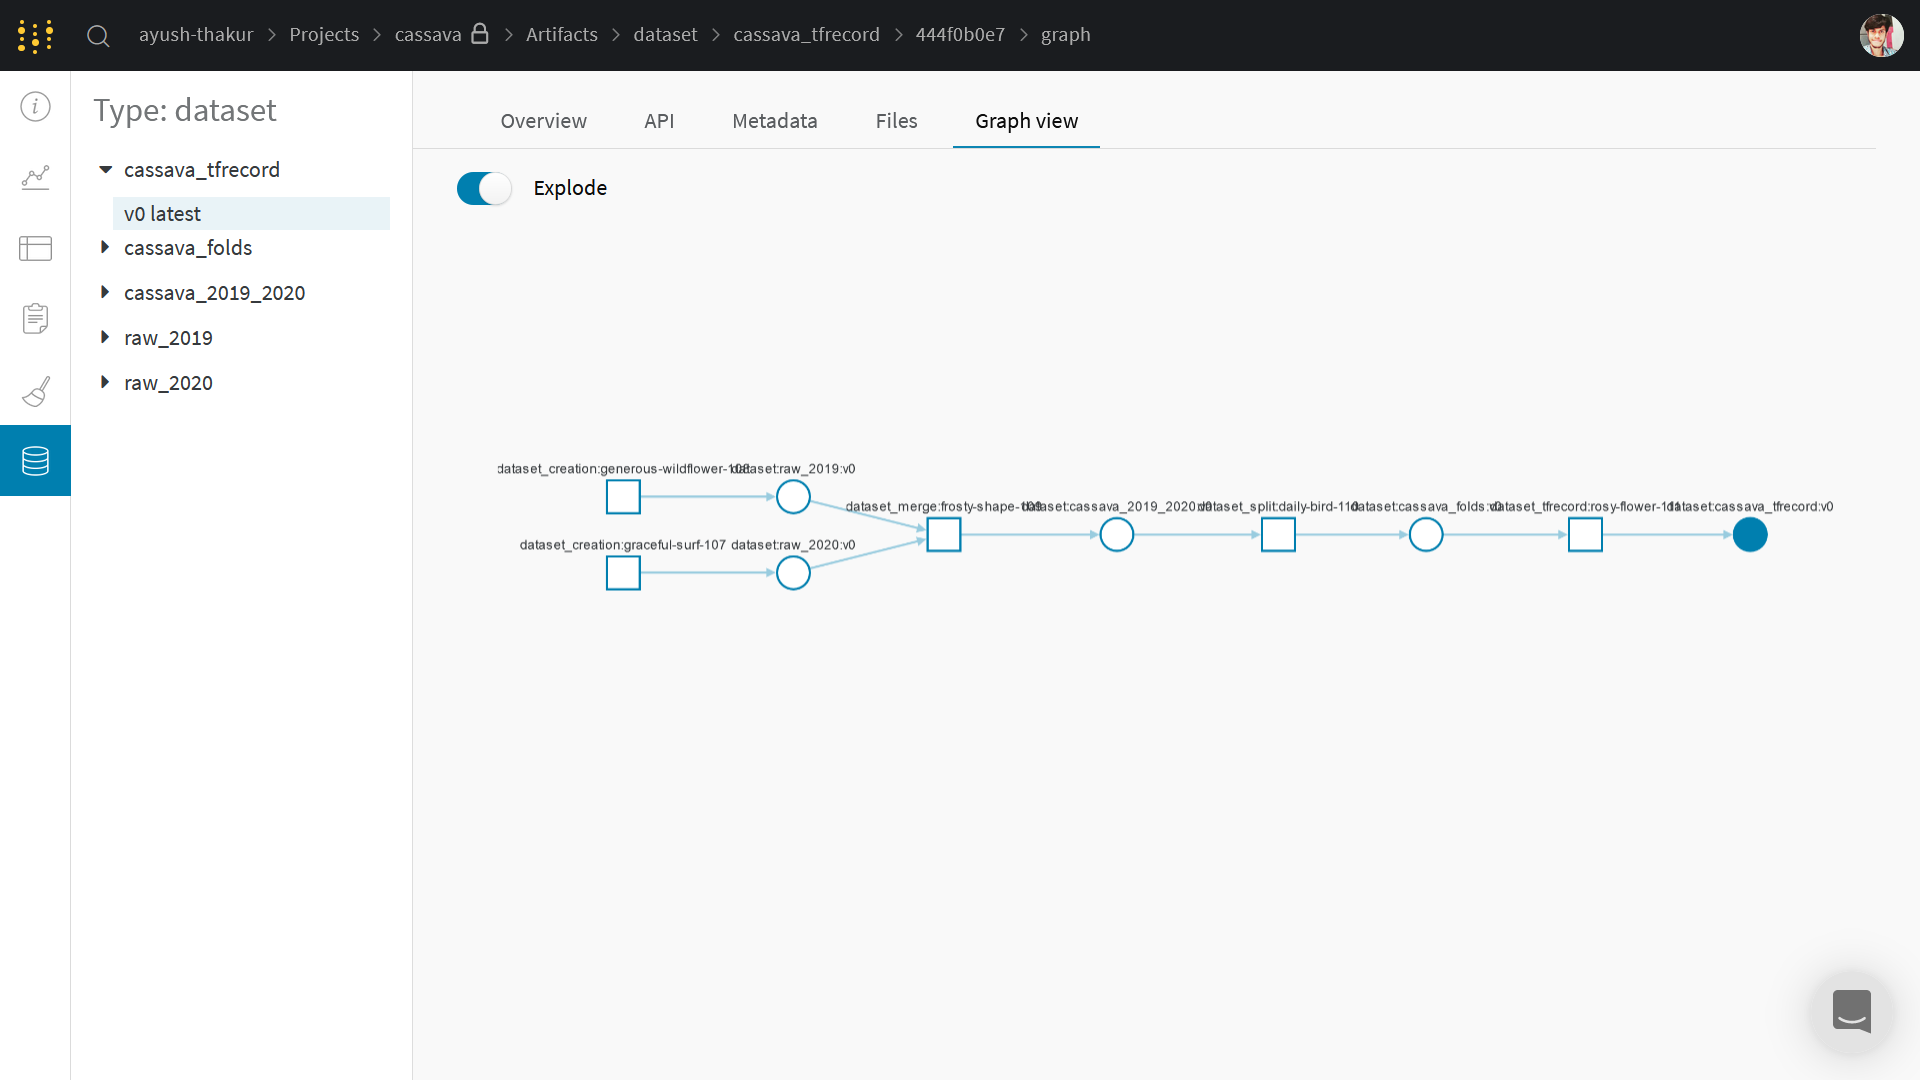

# Use the TFRecord Dataset

In order to use the dataset created use this code snippet:

```
import wandb
run = wandb.init()
artifact = run.use_artifact('ayush-thakur/cassava/cassava_tfrecord:v0', type='dataset')
artifact_dir = artifact.download()
```

The [training notebook](https://www.kaggle.com/ayuraj/efficientnet-mixup-k-fold-using-tf-and-wandb) will showcase the use W&B artifacts to download the dataset and train the model. 